## Text Classification with BERT




### Criando o ambiente virtual

Digite no terminal os seguintes comandos:

> python -m venv .venv

> .\\.venv\Scripts\activate



In [1]:
# ## Instalando as dependências necessárias
# ! pip install -q ipywidgets

# ! pip install -q pandas
# ! pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ! pip install -q transformers
#  ! pip install -q scikit-learn

# # Tratamento de dados
# ! pip install -U -q pip setuptools wheel
# ! pip install -U -q spacy
# ! python -m spacy download en_core_web_sm

### Importando dependencias


In [2]:
import re
import torch
import pandas as pd
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertModel,
    get_linear_schedule_with_warmup,
)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### Baixar CSV DAtaset

Usar o dataset obtido por meio do scraper

#### reviews scraper original, sem outliers


In [3]:
PATH_MODEL_SAVED= "savad_models/MultiClassClassifier_BERT_srapper_neutro_4567_without_outliers.pth"

In [4]:
# DATA_PATH = "D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_text.csv"
DATA_PATH= f"D:/tcc2/guilherme/2_Web_Scrapping/data/reviews_scraper_original.csv"
df = pd.read_csv(DATA_PATH)
df = df[['review','rating']]
df


,review,rating
0,This movie takes place off in fantasy land som...,1
1,"Too sentimental, too pathetic, too slow, too c...",1
2,There are some things in this life we will nev...,1
3,This movie was inspired by the brilliant Stir ...,1
4,"For the life of me, I can't understand all the...",1
...,...,...
44447,"Uma Thurman returns as the Bride, who this tim...",10
44448,"Quentin Tarantino's ""Kill Bill: Vol. 2"" comple...",10
44449,Vol 2 is completely different tone then the fi...,10
44450,This movie is great in that it mixes together ...,10


In [5]:
print("Valores duplicados",df.duplicated().sum())


Valores duplicados 16


In [6]:
df = df.drop_duplicates(ignore_index=True)
df


,review,rating
0,This movie takes place off in fantasy land som...,1
1,"Too sentimental, too pathetic, too slow, too c...",1
2,There are some things in this life we will nev...,1
3,This movie was inspired by the brilliant Stir ...,1
4,"For the life of me, I can't understand all the...",1
...,...,...
44431,"Uma Thurman returns as the Bride, who this tim...",10
44432,"Quentin Tarantino's ""Kill Bill: Vol. 2"" comple...",10
44433,Vol 2 is completely different tone then the fi...,10
44434,This movie is great in that it mixes together ...,10


In [7]:
print("value counts df['rating']:")
print(df["rating"].value_counts())



value counts df['rating']:
rating
10    6231
8     6226
9     6218
7     5799
6     4651
5     3745
1     3452
4     2962
3     2731
2     2421
Name: count, dtype: int64


In [8]:
# Supondo que 'df' é o seu DataFrame
menor_que_500 = df['review'].apply(lambda x: len(x) <= 800).sum()
print(f"A quantidade de reviews com tamanho menor que 800 é: {menor_que_500}")


A quantidade de reviews com tamanho menor que 800 é: 18149


In [9]:
import pandas as pd

# Número de avaliações
num_reviews = df['review'].count()

# Número médio de caracteres por avaliação
avg_chars = df['review'].apply(len).mean()

# Número médio de palavras por avaliação
avg_words = df['review'].apply(lambda x: len(x.split())).mean()

print(f"Número de avaliações: {num_reviews}")
print(f"Número médio de caracteres por avaliação: {avg_chars:.2f}")
print(f"Número médio de palavras por avaliação: {avg_words:.2f}")


Número de avaliações: 44436
Número médio de caracteres por avaliação: 1335.90
Número médio de palavras por avaliação: 233.44


In [10]:
def get_qtd_tokens(x):
    return len(x.split())
df.loc[:, 'qtd_tokens'] = df['review'].apply(get_qtd_tokens)

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_13532\2661111015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'qtd_tokens'] = df['review'].apply(get_qtd_tokens)


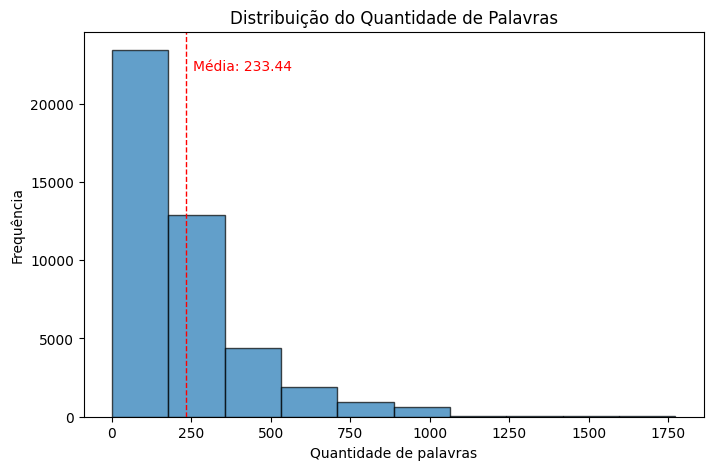

In [11]:
import matplotlib.pyplot as plt
# Plotar o gráfico
def plot_distr_qtd_palavras(series):
    mean_length = series.mean()

    plt.figure(figsize=(8, 5))
    plt.hist(series, edgecolor="k", alpha=0.7)
    plt.axvline(mean_length, color="r", linestyle="dashed", linewidth=1)
    plt.text(
        x=mean_length * 1.1,
        y=plt.ylim()[1] * 0.9,
        s=f"Média: {mean_length:.2f}",
        color="r",
    )
    plt.title("Distribuição do Quantidade de Palavras")
    plt.xlabel("Quantidade de palavras")
    plt.ylabel("Frequência")
    plt.show()


plot_distr_qtd_palavras(df["qtd_tokens"])

Q1:  106.0
Q3:  296.0
IQR:  190.0


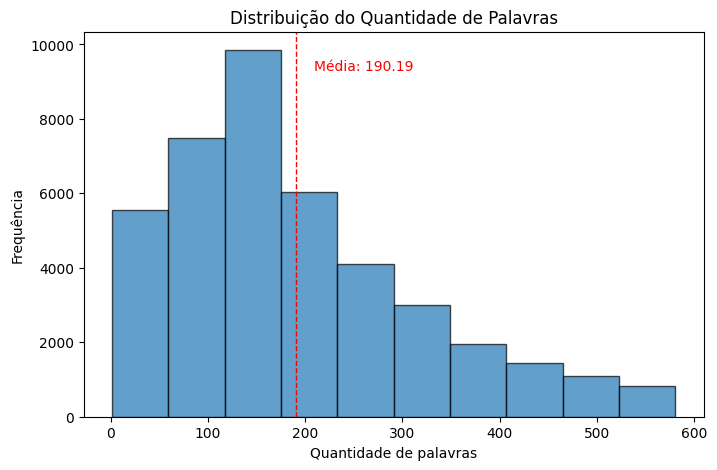

In [12]:
# Calcular o IQR
Q1 = df["qtd_tokens"].quantile(0.25)
Q3 = df["qtd_tokens"].quantile(0.75)
IQR = Q3 - Q1
print("Q1: ", Q1)
print("Q3: ", Q3)
print("IQR: ",IQR)
# Definir os limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remover outliers
df_without_outliers = df[
    (df["qtd_tokens"] >= lower_bound) & (df["qtd_tokens"] <= upper_bound)
]

plot_distr_qtd_palavras(df_without_outliers['qtd_tokens'])


In [13]:
df_without_outliers

,review,rating,qtd_tokens
0,This movie takes place off in fantasy land som...,1,62
1,"Too sentimental, too pathetic, too slow, too c...",1,32
2,There are some things in this life we will nev...,1,300
3,This movie was inspired by the brilliant Stir ...,1,133
4,"For the life of me, I can't understand all the...",1,72
...,...,...,...
44430,After a bloody good time in Vol. 1 watching Um...,10,235
44431,"Uma Thurman returns as the Bride, who this tim...",10,243
44433,Vol 2 is completely different tone then the fi...,10,41
44434,This movie is great in that it mixes together ...,10,111


In [14]:
# Iterar sobre cada categoria
def balance_dataframe_groups(df,column, NUM_ROWS_PER_CATEGORY):
    # Lista para armazenar os DataFrames de cada categoria(um por categoria)
    df_list_rating = []
    for rating, group in df.groupby(column):
        rating_str = str(rating)  # Convertendo para string
        num_samples = min(NUM_ROWS_PER_CATEGORY[rating_str], len(group))
        # Selecionar aleatoriamente o número correto de linhas para cada categoria
        sampled_rows = group.sample(n=num_samples, random_state=42)
        # Adicionar os dados selecionados à lista
        df_list_rating.append(sampled_rows)
    balanced_df =pd.concat(df_list_rating)
    return balanced_df 

In [15]:
df_without_outliers['rating'].value_counts()

rating
8     5651
9     5591
10    5435
7     5419
6     4417
5     3578
1     3383
4     2840
3     2659
2     2378
Name: count, dtype: int64

In [ ]:
# Definido para situacao onde a classe neutra vai representar os ratings [4,5,6,7]
NUM_ROWS_PER_CATEGORY = {
    "1": 2000,
    "2": 2000,
    "3": 2000,
    "4": 1500,
    "5": 1500,
    "6": 1500,
    "7": 1500,
    "8": 2000,
    "9": 2000,
    "10": 2000,
}
# Obter dataframe balenceado
balanced_df = balance_dataframe_groups(df_without_outliers, "rating", NUM_ROWS_PER_CATEGORY)

# Verificar se as categorias estão balanceadas
print(balanced_df["rating"].value_counts())

Criar Dataframe de teste

Os dados de teste não são usados durante o treinamento do modelo e nem na validaçõa


In [ ]:
# Crie uma série com todos os índices únicos
# df original 
df_indices = pd.Series(df.index)
# Crie uma série com os índices que estão no balanced_df
balanced_indices = pd.Series(balanced_df.index)
# Selecione os índices que não estão no balanced_df
indices_teste = df_indices[~df_indices.isin(balanced_indices)]
# Crie um novo dataframe com os índices não presentes no balanced_df
df_teste = df.loc[indices_teste]


In [16]:
df_teste['rating'].value_counts()

NameError: name 'df_teste' is not defined

In [17]:
def categorize_rating(rating):
    # classe negativa[1,2,3]
    if int(rating) <= 3:
        return 0
    # Classe neutra se rating in [4,5,6,7]
    elif int(rating) <= 7:
        return 1
    # Classe positiva se rating in [8,9,10]
    else:
        return 2

balanced_df["rating"] = balanced_df["rating"].apply(categorize_rating)
df_teste["rating"] = df_teste["rating"].apply(categorize_rating)
print(balanced_df["rating"].value_counts())
print(df_teste["rating"].value_counts())


NameError: name 'balanced_df' is not defined

In [ ]:
# Supondo que 'df' é o seu DataFrame
tam_fitlro = 580
_  = balanced_df['review'].apply(lambda x: get_qtd_tokens(x) >= 580).sum()
print(f"A quantidade de reviews com tamanho maior que {tam_fitlro} é: {_}")


In [ ]:
df_teste

In [ ]:
def load_texts_labels(df):
    texts = df["review"].tolist()
    labels = df["rating"].tolist()
    return texts, labels

In [ ]:
def maior_text(texts):
    maior_string = max(texts, key=lambda x: len(x.split()))
    return maior_string

In [ ]:
texts, labels = load_texts_labels(balanced_df)
test_texts , test_labels = load_texts_labels(df_teste)

maior_string = maior_text(texts)
tam_maior_string = len(maior_string)
qtd_pal_maior_String = len(maior_string.strip(" "))
print(maior_string)
print(qtd_pal_maior_String)

maior_string = maior_text(test_texts)
tam_maior_string = len(maior_string)
print(tam_maior_string)

## Construindo nosso modelo

Vetorização dos dados usando tokenizador do Bert


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label),
        }

In [ ]:
class MultiClassClassifier(nn.Module):
    def __init__(self, bert_model_name: str, hidden_size: int, num_classes: int):
        super(MultiClassClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs_bert.pooler_output
        drop = self.dropout(pooled_output)
        logits = F.relu(self.linear1(drop))
        logits = self.linear2(logits)

        return logits

In [ ]:
def train_model_epoch(
    model: MultiClassClassifier, data_loader, optimizer, scheduler, loss_func, device
):
    model.train()
    losses = []
    model_prediction = []
    actual_labels = []
    for batch in tqdm(data_loader, colour="green", desc="Train_epoch: "):
    
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_func(outputs, labels)
        loss.backward()
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        model_prediction.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        optimizer.step()
        scheduler.step()

    train_accuracy = accuracy_score(actual_labels, model_prediction)
    train_loss = np.mean(losses)


    return train_accuracy, train_loss

In [ ]:
def eval_model_epoch(
    model: MultiClassClassifier, data_loader: TextClassificationDataset,loss_func, device: str
):
    model.eval()
    losses = []
    model_prediction = []
    actual_labels = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, colour="blue", desc="Validation_epoch: "):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            model_prediction.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            correct_predictions += torch.sum(preds == labels)
            loss = loss_func(outputs, labels)
            losses.append(loss.item())
    val_losses = np.mean(losses)
    val_accuracies = accuracy_score(actual_labels, model_prediction)
    report = classification_report(actual_labels, model_prediction,output_dict=True)
    return (val_accuracies, val_losses, report)

In [ ]:
# Set up parameters
BERT_MODEL_NAME = "bert-base-uncased"
hidden_size = 10  # Tamanho caamda oculto, neuronios
num_outputs = 3  # numero de classes de saida [negativo,neutro, positivo]
max_length = 256  # 128,256,512
batch_size = 4  # 8, 16, 32 (tamanho do lote na iteracao, treinamento e classe)
num_epochs = 4  # recomended in the Bert Article [2,3,4]
learning_rate = 3e-5  # Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# teste
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.15, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)


In [ ]:
train_dataset = TextClassificationDataset(
    train_texts, train_labels, tokenizer, max_length
)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_outputs).to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)# adicionado #correct_bias=False
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
loss_func = nn.CrossEntropyLoss().to(device)

In [ ]:
history = {
    "train_losses": [],
    "train_accuracies": [],
    "val_losses": [],
    "val_accuracies": [],
    "val_reports": [],
}

best_accuracy = 0
epochs_without_improvements = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 50)
    # Treinamento
    train_accuracy, train_loss = train_model_epoch(
        model, train_dataloader, optimizer, scheduler, loss_func, device
    )
    # Validation
    val_accuracy, val_loss, report = eval_model_epoch(
        model, val_dataloader, loss_func, device
    )

    history["train_losses"].append(train_loss)
    history["train_accuracies"].append(train_accuracy)
    history["val_losses"].append(val_loss)
    history["val_accuracies"].append(val_accuracy)
    history["val_reports"].append(report)
    
    print(f"Train => Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")
    print(f"Validation => Loss = {val_loss:.4f}, Accuracy = {val_accuracy:.4f}")
    print(report)
    print()
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), PATH_MODEL_SAVED)
        epochs_without_improvements = 0
        best_accuracy = val_accuracy
    else:
        epochs_without_improvements += 1

    if epochs_without_improvements > 4:
        break

In [ ]:
history

In [ ]:
import matplotlib.pyplot as plt


train_loss = history["train_losses"]
val_loss = history["val_losses"]
# Plotting the training and validation loss
def plot_loss_fun_graph(train_loss, val_loss):
    plt.plot(train_loss, "r", label="Training loss")
    plt.plot(val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    
plot_loss_fun_graph(train_loss, val_loss)


# Plotting the training and validation accuracy
train_acc = history["train_accuracies"]
val_acc = history["val_accuracies"]
# Encontrar o índice do melhor valor de acurácia de validação
def plot_accurary_graph(train_acc, val_acc):
    best_epoch = np.argmax(val_acc)
    best_accuracy = val_acc[best_epoch]
    plt.clf()
    plt.plot(train_acc, "r", label="train accuracy")
    plt.plot(val_acc, "b", label="validation accuracy")
    # Adicionar texto para destacar o melhor valor de acurácia de validação
    plt.text(
        best_epoch,
        best_accuracy,
        f"{best_accuracy:.2f}",
        fontsize=12,
        ha="left",
    )
    plt.title("Training and validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.show()


plot_accurary_graph(train_acc, val_acc)

In [ ]:
history['val_reports'][2]

## Saving & Loading Model for Inference

Save:


In [ ]:
# PATH_MODEL_SAVE = "sentiment_classifier_Bert_IMDB_Dataset_eith_lemma.pth"
# torch.save(model.state_dict(), PATH_MODEL_SAVE)

load:


In [ ]:
# # PATH_MODEL_SAVE = "sentiment_classifier_en_49500_reviews.pth"
# saved_model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_outputs).to(device)
# saved_model.load_state_dict(torch.load(PATH_MODEL_SAVE))
# # saved_model.eval()

### Evaluation in test_data


### Get predicitons in test_texts and test_labels

In [ ]:
def get_predictions(model, data_loader, device):
    model = model.eval()

    # corresponde ao indice(classe) com maior probabilidade na saída do modelo
    predictions = []
    # corresponde ao indice real(classe verdadeira)
    real_values = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            m_output = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(m_output, dim=1)

            _, max_index = torch.max(probs, dim=1)

            predictions.extend(max_index)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, real_values

In [ ]:
#  CArregando com o modelo final atualizado
test_predictions, test_real_values=get_predictions(model,test_dataloader,device)

In [ ]:
classes_names = ["negativo",'neutro', "positivo"]
test_report = classification_report(
    test_predictions, test_real_values, target_names=classes_names, output_dict=False
)

print(test_report)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_predictions,test_real_values)
cm_display = ConfusionMatrixDisplay(cm,display_labels=classes_names).plot()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_predictions,test_real_values)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm)



## Sentiment prediction

In [ ]:
import spacy
def predict_tratamento_texto(text: str, lemma:bool):
    # nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(re.compile("<.*?>"), "", text)
    # doc = nlp(text)
    # if lemma == True:
    #     text = " ".join(
    #         [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    #     )  # retorna o lemma
    # else:
    #     text = " ".join(
    #         [token.text for token in doc if not token.is_stop and not token.is_punct]
    #     )  # return text
    return text


In [ ]:

def predict_sentiment(
    text: str,
    model: MultiClassClassifier,
    tokenizer: BertTokenizer,
    device: str,
    max_length: int,
    lemma=False,
):
    model.eval()
    text = predict_tratamento_texto(text, lemma)
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = torch.nn.functional.softmax(output,dim=1)
    prob_neg = prob[0, 0].item()
    prob_neutra=prob[0,1].item()
    prob_pos = prob[0, 2].item()
    print(f"prob negativa: {prob_neg:.5f}")
    print(f"prob neutra: {prob_neutra:.5f}")
    print(f"prob positiva: {prob_pos:.5f}")

    classes = ["negativo", "neutro", "positivo"]
    predicted_class_index = torch.argmax(prob, dim=1).item()
    predicted_class = classes[predicted_class_index]
    return predicted_class

In [ ]:
# Challengers 1/10
text= """The audience was in hysterics by the end. The choices made in every aspect of this movie were shockingly bad. The abysmal and strange music, the constant shift in time, the laughable script, the nauseating camera work, and just truly one of the worst directed films I've ever seen. I would have left halfway through if I didn't have to pay for my food. But I'm glad I stayed because it got so much more hysterically bad than I even thought possible. I feel like I'm insane because the audience was screaming with laughter. I got the sense that the director thinks he's a genius, but this movie is 1% short of a feature length SNL parody."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# The Fall Guy 2/10
text = """Almost ok! But not good or great. Could had been.

It was evident that the makers of this movie never saw more than couple of episodes of Fall guy the TV series it's based on. There were more reference to Miami vice tv series than the actual tv series this movie is supposedly based on. First half an hour or so of the movie was pure cringe. The dialogues were written by couple of teenagers who were probably paid in TikTok views. The rom com scenes were cringy and unwatchable.

Action sequences and stunts were excellent but kept getting interrupted by really really awful cringy love story. One scene ( not a spoiler) where the action sequence keeps breaking away to a cringey Karakoram no , made us almost walk out of the movie.

Some of the acting is sooo bad.

If you make a movie based on the TV series Atleast watch every episode of it. We did. The tv series that made every kid want to get a pickup truck and be a stunt man. The tv series which made kids attempt dangerous stunts on their bikes.

And the actual fall guy Lee majors. Makes an appearance post credit? Really. Why even bother.

Was ok but a missed opportunity to make it great."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# THe Idea of You 3/10
text= """Oh dear. Absolutely no chemistry between the two main characters. The lead female Solene, apart from the absurd name is totally unrelatable or endearing. She acts like his teacher, or mother "I'll make you a sandwich?!" When she talks about herself he's uncomfortably interested, uncomfortable because it's not believable. The art they show in the gallery and warehouse are pretentious and boring, a lot like Solene.
      
I'm surprised at the positive reviews.

It's mildly entertaining - a background movie for when you're building Lego for example. But I couldn't take the pairing seriously. Maybe I'm feeling the uncomfortable atmosphere that potentially could have been on set that I'm picking up on? I dunno. It could've been so much better with a different female lead."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# nota 4
text= """I'm a big fan of Garland's earlier films (Ex Machina, Annihilation) and wanted to like this, but sadly this one was a miss. There's not really a story - no reason why the war is happening or what is at stake. The characters are extremely unrelatable and are more there just to represent concepts (the media, racism, etc) rather than have any identity of their own. The war just happens to be there in the background while the characters are taking a roadtrip through rural America, which doesn't actually show any war going on, just random series of fights which could just be regular gun violence from today. You would hardly know there's a war going on except the characters telling you there is.

It's not until the last 10 minutes that you see any military operations and it lacks scale for only seemingly having about 100 troops fighting, given what's supposedly at stake. The movie should've started here and gone backwards into why the war is happening, which would've made a more interesting film in my opinion.

"""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# Anyone But You 5/10

text = """They really did make a whole movie just to show off Glen Powell's smoking hot body and honestly - I'm here for it!

The storyline and the acting is... wait, who cares?? Glen Powell is shirtless about half the time.

This is a movie about two people who fall in love only to find out that... Glen Powell's body is so hot!

If you watch the trailer you already know exactly what happ... Glen Powell!!

The predictability factor is super strong with this one. The cheese is sprinkled all over the movie, in every scene, there is little room left for any other ingredients because... cheese. And Glen Powell.

Glen Powell"""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# Capita marvel 2019 5/10
text = """Plot

Carol Danvers     becomes one of the universe's most powerful heroes when Earth is caught in the middle of a galactic war between two alien races.

Cast

Brie Larson, Samuel L. Jackson (Because duh), Jude "Just consistently dreadful" Law, Annette Bening, Djimon Hounsou, Clark Gregg and blink and you'll miss him Lee Pace who returns as Ronan but looks so different I didn't even think it was him.

Verdict

I watched this back when it was initially released, I watched it a second time a few days ago as the missus is wanting us to binge watch the entire MCU as she's very behind. My opinion has changed on the 2nd viewing and not in a good way, my rating has shifted from a 6/10 to 5/10.

You see straight out of the gate the first thing you notice about Carol Danvers is she's not really a character you can get behind. She's not funny, she's not entertaining, she comes across as a surly teenage girl who is just upset at the slightest thing and just doesn't want to be there. This is not a character you can build a movie around, like trying to make a teenage Groot movie! It wouldn't work, but he's okay as a side character.

Supporting cast are also hit and miss, Jackson and Gregg are great, but Lynch and Law just stink up every scene they're in.

I'm a Marvel fan but I recognize where it's weak, this is a distinctly average film that serves as a standalone origin story and doesn't contribute much to the universe as a whole.

Rants

I remember when the movie came out all the controversy with Brie Larson, I just had to Google what the controversy even was as I don't remember due to not focusing on such things. Now I can't really get a definitive answer. From what I see it's a combination of people not liking her attitude and her comments on feminism. So I Googled further to see what she said, she came across arrogant in them and a smidge out of touch but none of it explained the overwhelming hate I've seen aimed at her. Then I remembered that people talk about all the different types of bigotry but misogyny rarely comes up, I remembered that it's visibly increased over the past decade and appreciated why she's been targeted. News flash, the outspoken loud brash man hating femnists you likely thing of when you hear that word make up a very small percentage. Feminism is good, if you disagree I hope you simply don't know the meaning of the word.

The Good

Jackson and Gregg Has a couple of decent moments Not a bad soundtrack Goose!

The Bad

Larson isn't great Law and Lynch are terrible Lead just comes across unlikable.

Overall just a weak entry to the MC
"""

In [ ]:
# nota 5 = neutra
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# CApita marvel 2019 6/10
text="""Mediocre Marvel is still pretty good.

My first review in a long time! Dont know why I decided to write about this movie.

I agree with most mediocre reviews I read here.

The pacing was pretty good.

Most of the action was good!

The story was ok and had some good twists.

I thought about giving this movie a 6 but after letting it sink in I decided to give it 8 out of 10

It entertained me and my company from beginning to end.

There were some eye rolling moments but they are easily forgiven."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# Duna parte 2 6/10
text ="""Dune Part 2 is an epic movie; slickly made, and visually stunning.

But I had to explain quite a bit to the friends around me who had not read the book, especially the water of life scene and the final battle.

The movie had almost a 3 hour run time, but it felt overlong because Villenue focuses too much on spectacle on very little on substance.

It is a beautiful movie, but it feels like it has no soul. The emotional connection between Paul and Chani, so vital to the story, is completely lacking and unbelievable. The two main characters are good looking enough but has absolutely zero chemistry on screen.

I am certain Zendaya is a fine actress in some things, but she has basically 2 facial expressions here, and the one she uses the most is a scowl directed at Paul. I found her to be the worst part of this movie.

The final fight scene is short, choppy, and a mess. It felt anticlimactic and unfulfilling The Harkonens are basically reduced to bumbling villainy almost cartoonish. The ending was super abrupt, and was so different from the book that it left me wondering what the filmmakers would do if they want to do a sequel.

I want to reiterate that this isn't a bad movie. Villenue is great at creating a world that looks living and breathing, but he can't give life to individual characters.

It is like he can't see the trees for the forest."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# duna parte 2 7/10

text ="""I mean, yeah, it's very entertaining and, of course, very visually stunning. The set pieces, the cinematography, the use of visual effects and lights, the sound design and music, all, absolutely amazing and almost literally stunning!

But then? I'm not really seeing much after that. As I have not read the books, this movie was a total mystery to me. There's barely any dialog--at least not any that would explain anything what's going on at all. The world and the technology etc just doesn't make much sense to me.

None of the characters are particularly interesting, to be honest. They don't really have that much personality to them, and even if they did, they didn't really make me care about them all that much.

I don't know, I'm a bit conflicted, it wasn't a bad movie and, as I said, it was entertaining and visually mesmerizing, but it lacked the depth that I was expecting of a world this size and this rich with lore and history. Maybe the movie makers assumed everyone has read the books? As someone to who the world is not familiar at all, it just seems rather confusing and strange. I feel like they just focused on making it as visually awesome as they can (in which they arguably succeeded), but left the story on the pages of the books."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# Love Lies Bleeding (2024) 8/10

text="""Love Lies Bleeding is a bigger, bolder, and more violent follow-up feature for Rose Glass. It literally puts the premise of Thelma & Louise on steroids with a very muscular approach that goes for broke in its ending which, love it or hate it, is to be commended for its audacity. Body horror, romance, and dark comedy are all blended into one distinctive vision.

Kristen Stewart is amazing, awkward and off hand with one of the best dramatic pauses of recent memory. Katy O'Brian has been massively under served by her roles in the big franchises which makes this much more layered performance all the more satisfying. Together, their chemistry is instant and they communicate how badly they want each other so well.

Ed Harris has played a lot of villains so its a real testament to his performance and the writing of the character that this one still stands out. His long haired, bug eating gangster makes for a consistently creepy highlight. Also, Dave Franco does a great job as a spineless abusive husband who's fate is obvious and all the more satisfying because of how he plays it.

Saint Maud definitely wasn't lacking in vision but Rose Glass has really upped her craft here. From its reality manipulating opening scene to the extreme close ups of muscles in action, it's clear that the film will move between extremes as it deftly balances the violence and body horror against an affecting romance that refuses to go for the most obvious outcomes.

The sound design and editing here is so visceral. Gunshots feel scary as they often come out of nowhere and the way scenes can abruptly switch between very different soundscapes keeps you on edge. Clint Mansell's score really matches the song choices for a seamless soundtrack whilst being completely distinct."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# The Godfather Part II (1974) 9/10
text ="""Although the casual way it has been titled leaves it with plenty to answer for, 'Godfather II' rightly remains the only sequel ever to win an Oscar for Best Picture of the year.

With Brando out of the picture the focus has shifted to Michael and much more money was obviously available to spend on the movie itself (with plush production design and cool fifties cars gliding across the screen a recurrent motif).

Robert De Niro as the young Don Corleone brings a lean and hungry look to the part by then completely beyond Brando (by comparison Al Pacino looks much older).

The film is far more ambitious, both technically and thematically, addressing America's changing role in the world rather than just the activities of one family."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# The Godfather Part II (1974) 10/10

text = """One of the all time greats. Or probably the alone greatest thing ever made in the history of cinematography. This movie is both "prequel" and "sequel" of the first godfather movie. I have never watched anything like this in my entire life. This movie has explained the life of underworld people in a great way. It also shows how vengeance eradicates happiness from your life. People don't even care about their family in greed of power. It's a masterpiece that can never be written off even after centuries. Even if you are not into these kind of movies, I will suggest to watch it for atleast once in your life or you'll be deprived of one of the greatest things to watch that have been ever made."""

In [ ]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

### Simples test sentiment prections

In [ ]:
# Test sentiment prediction
test_text = "The movie was so bad and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Texto: ", test_text)
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# Test sentiment prediction
test_text = "Best movie of the year. "
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Worst movie of the year.")
print(f"Predicted sentiment: {sentiment}")

In [ ]:
# Test sentiment prediction
test_text = "This movie is more or less,and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print(test_text)
print(f"Predicted sentiment: {sentiment}")